# 데이터 로드

In [1]:
import numpy as np
import pandas as pd

In [2]:
# train_original = pd.read_excel('../01-2. Raw Data (Open)/open_train_data.xlsx')
train_original = pd.read_excel('../01-2. Raw Data (Open)/open_train_data.xlsx')
print(train_original.shape)
train_original.head()

(39000, 2)


,label,text
0,1,Awesome Movie: The Cheetah Girls was a great m...
1,0,Not what I expect from Dean Koontz: I wish Dea...
2,0,Not loud enough for use in a crowd.: This prod...
3,0,"Not Again: I used to be a huge Hanson fan, so ..."
4,1,"What a Blessing {even as an adult): So, I admi..."


In [3]:
test_original = pd.read_excel('../02. Train_Test Data/bidet_test_data.xlsx')
# test_original = pd.read_excel('/content/drive/MyDrive/데이터 분석/07. 1차 프로젝트/02. Train_Test Data/bidet_test_data.xlsx')
print(test_original.shape)
test_original.head()

(13095, 2)


,label,text
0,0,Beware of hidden constraints.The online descri...
1,1,Great Features....This is actually the second ...
2,1,Excellent Product.This is the third Bio Bidet ...
3,1,Life Changer.My husband purchased this bidet f...
4,1,great features..I now have 3 bidets. 2 in our ...


## 카피본

In [4]:
train = train_original.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39000 entries, 0 to 38999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   39000 non-null  int64 
 1   text    39000 non-null  object
dtypes: int64(1), object(1)
memory usage: 609.5+ KB


In [5]:
test = test_original.copy()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13095 entries, 0 to 13094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   13095 non-null  int64 
 1   text    13095 non-null  object
dtypes: int64(1), object(1)
memory usage: 204.7+ KB


In [6]:
# 데이터 로딩
train_data = train['text']  # 훈련 데이터셋
train_labels = train['label']  # 훈련 데이터셋 라벨
test_data = test['text']  # 테스트 데이터셋
test_labels = test['label']  # 테스트 데이터셋 라벨

# 1st Trial

## 전처리 : 소문자화, 불용어/구두점 제거

In [37]:
train_data = [str(text) for text in train_data]
test_data = [str(text) for text in test_data]

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # 불용어 사전 다운로드
nltk.download('wordnet')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
# 형태학적 분석으로 단어의 원형 추출 : 정확한 결과 but 느린 속도
stemmer = PorterStemmer()
# 어미 제거로 어간 추출 : 빠른 속도 but 일부 단어의 원형을 제대로 추출하지 못함

def preprocess_text(text):      
    text = text.lower() # 소문자 변환
    text = re.sub(r'\.+', ' ', text)  # 중복 온점 제거
    text = text.replace('&', 'and') # & 제거
    
    punctuations = '\"#$%*+,/<=>@[\]^_`\\\\{|}?!~:;()'
    for p in punctuations :
        text = text.replace(p, ' ') # 구두점 제거
    
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = re.sub(r'\s+', ' ', text)  # 중복 공백 제거
#     text = re.sub(r'(\w)(\1{1,})', r'\1', text) # 알파벳 3회이상 반복시 1개로
      
#     # 구두점 제거
#     text = ''.join(char for char in text if char not in punctuations)
#     # 불용어 제거
#     text = ' '.join(word for word in text.split() if word not in stop_words)

#     # 표제어 추출
    words = [lemmatizer.lemmatize(word) for word in text.split()]
#     # 어간 추출
#     words = [stemmer.stem(word) for word in text.split()]

#     return ' '.join(words)
    return text.strip()


# train_data와 test_data에 대해 전처리 수행
preprocessed_train_data = [preprocess_text(text) for text in train_data]
preprocessed_test_data = [preprocess_text(text) for text in test_data]

print(train_data[:2])
print(preprocessed_train_data[:2])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


["Awesome Movie: The Cheetah Girls was a great movie. It is one of the best movies I've ever seen. I liked the way the girls danced, but one girl took what they were doing too seriously. I haven't seen the DVD yet,but I saw the movie on Disney channel and I loved it. I can't wait to see the DVD!", "Not what I expect from Dean Koontz: I wish Dean Koontz would get back to the quailty of work I have become used to, as in The Watchers, Dark Rivers of the Heart, Lightning, etc. I could go on and on but his latest works have left me flat. I don't know that I'll read the third book in this series (although I probably will). Come on Dean give me a page turner that I can't put down."]
["awesome movie the cheetah girls was a great movie it is one of the best movies i've ever seen i liked the way the girls danced but one girl took what they were doing too seriously i haven't seen the dvd yet but i saw the movie on disney channel and i loved it i can't wait to see the dvd", "not what i expect from

## Gradient Boosting 사용 

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# 벡터화를 위한 파라미터 설정
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_features=10000)
tfidf_transformer = TfidfTransformer()

# train 데이터와 validation 데이터를 분리
train_x, valid_x, train_y, valid_y = train_test_split(preprocessed_train_data, train_labels, train_size=0.8, random_state=42)

# GBM 모델 생성
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

# 파이프라인 생성
pipeline = Pipeline([
    ('vect', vectorizer),
    ('tfidf', tfidf_transformer),
    ('clf', gbm_model),
])

# 모델 훈련
pipeline.fit(train_x, train_y)

print('end')

end


### 78.47%

In [39]:
# 모델 성능 평가
train_predicted_labels = pipeline.predict(train_x)
train_accuracy = accuracy_score(train_y, train_predicted_labels)
print(f"Train Accuracy: {train_accuracy:.4f}")

# 검증 데이터로 모델 평가
valid_predicted_labels = pipeline.predict(valid_x)
valid_accuracy = accuracy_score(valid_y, valid_predicted_labels)
print(f"Validation Accuracy: {valid_accuracy:.4f}")

# 테스트 데이터로 모델 성능 평가
test_predicted_labels = pipeline.predict(preprocessed_test_data)
test_accuracy = accuracy_score(test_labels, test_predicted_labels)
print(f"Test Accuracy with best parameters: {test_accuracy:.4f}")

Train Accuracy: 0.8304
Validation Accuracy: 0.8105
Test Accuracy with best parameters: 0.7847


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

print("Test")
# 혼동 행렬 출력
print(confusion_matrix(test_labels, test_predicted_labels))
# 분류 보고서 출력
print(classification_report(test_labels, test_predicted_labels))

Test
[[1689  139]
 [2681 8586]]
              precision    recall  f1-score   support

           0       0.39      0.92      0.55      1828
           1       0.98      0.76      0.86     11267

    accuracy                           0.78     13095
   macro avg       0.69      0.84      0.70     13095
weighted avg       0.90      0.78      0.82     13095



### 과적합 검증

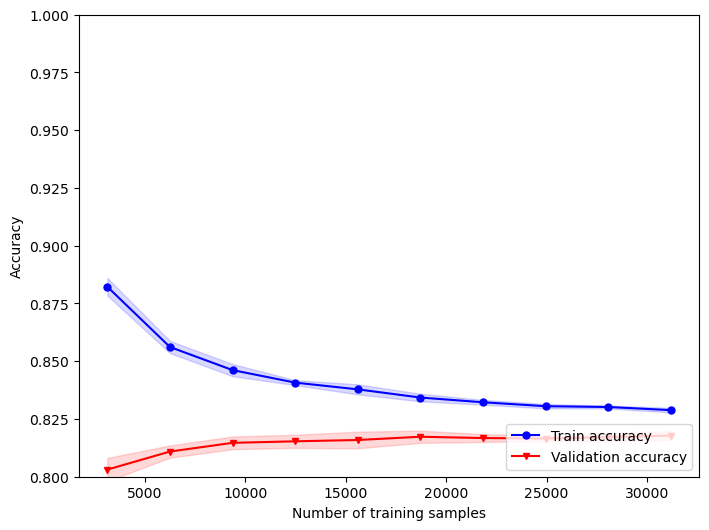

In [41]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=pipeline,
    X=preprocessed_train_data, y=train_labels,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)


plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Train accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, validation_mean, color='red', marker='v', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, validation_mean + validation_std, validation_mean - validation_std, alpha=0.15, color='red')


plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])

# 그래프를 이미지 파일로 저장합니다.
filename = 'GB_Open_기본.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

## 이미지 저장

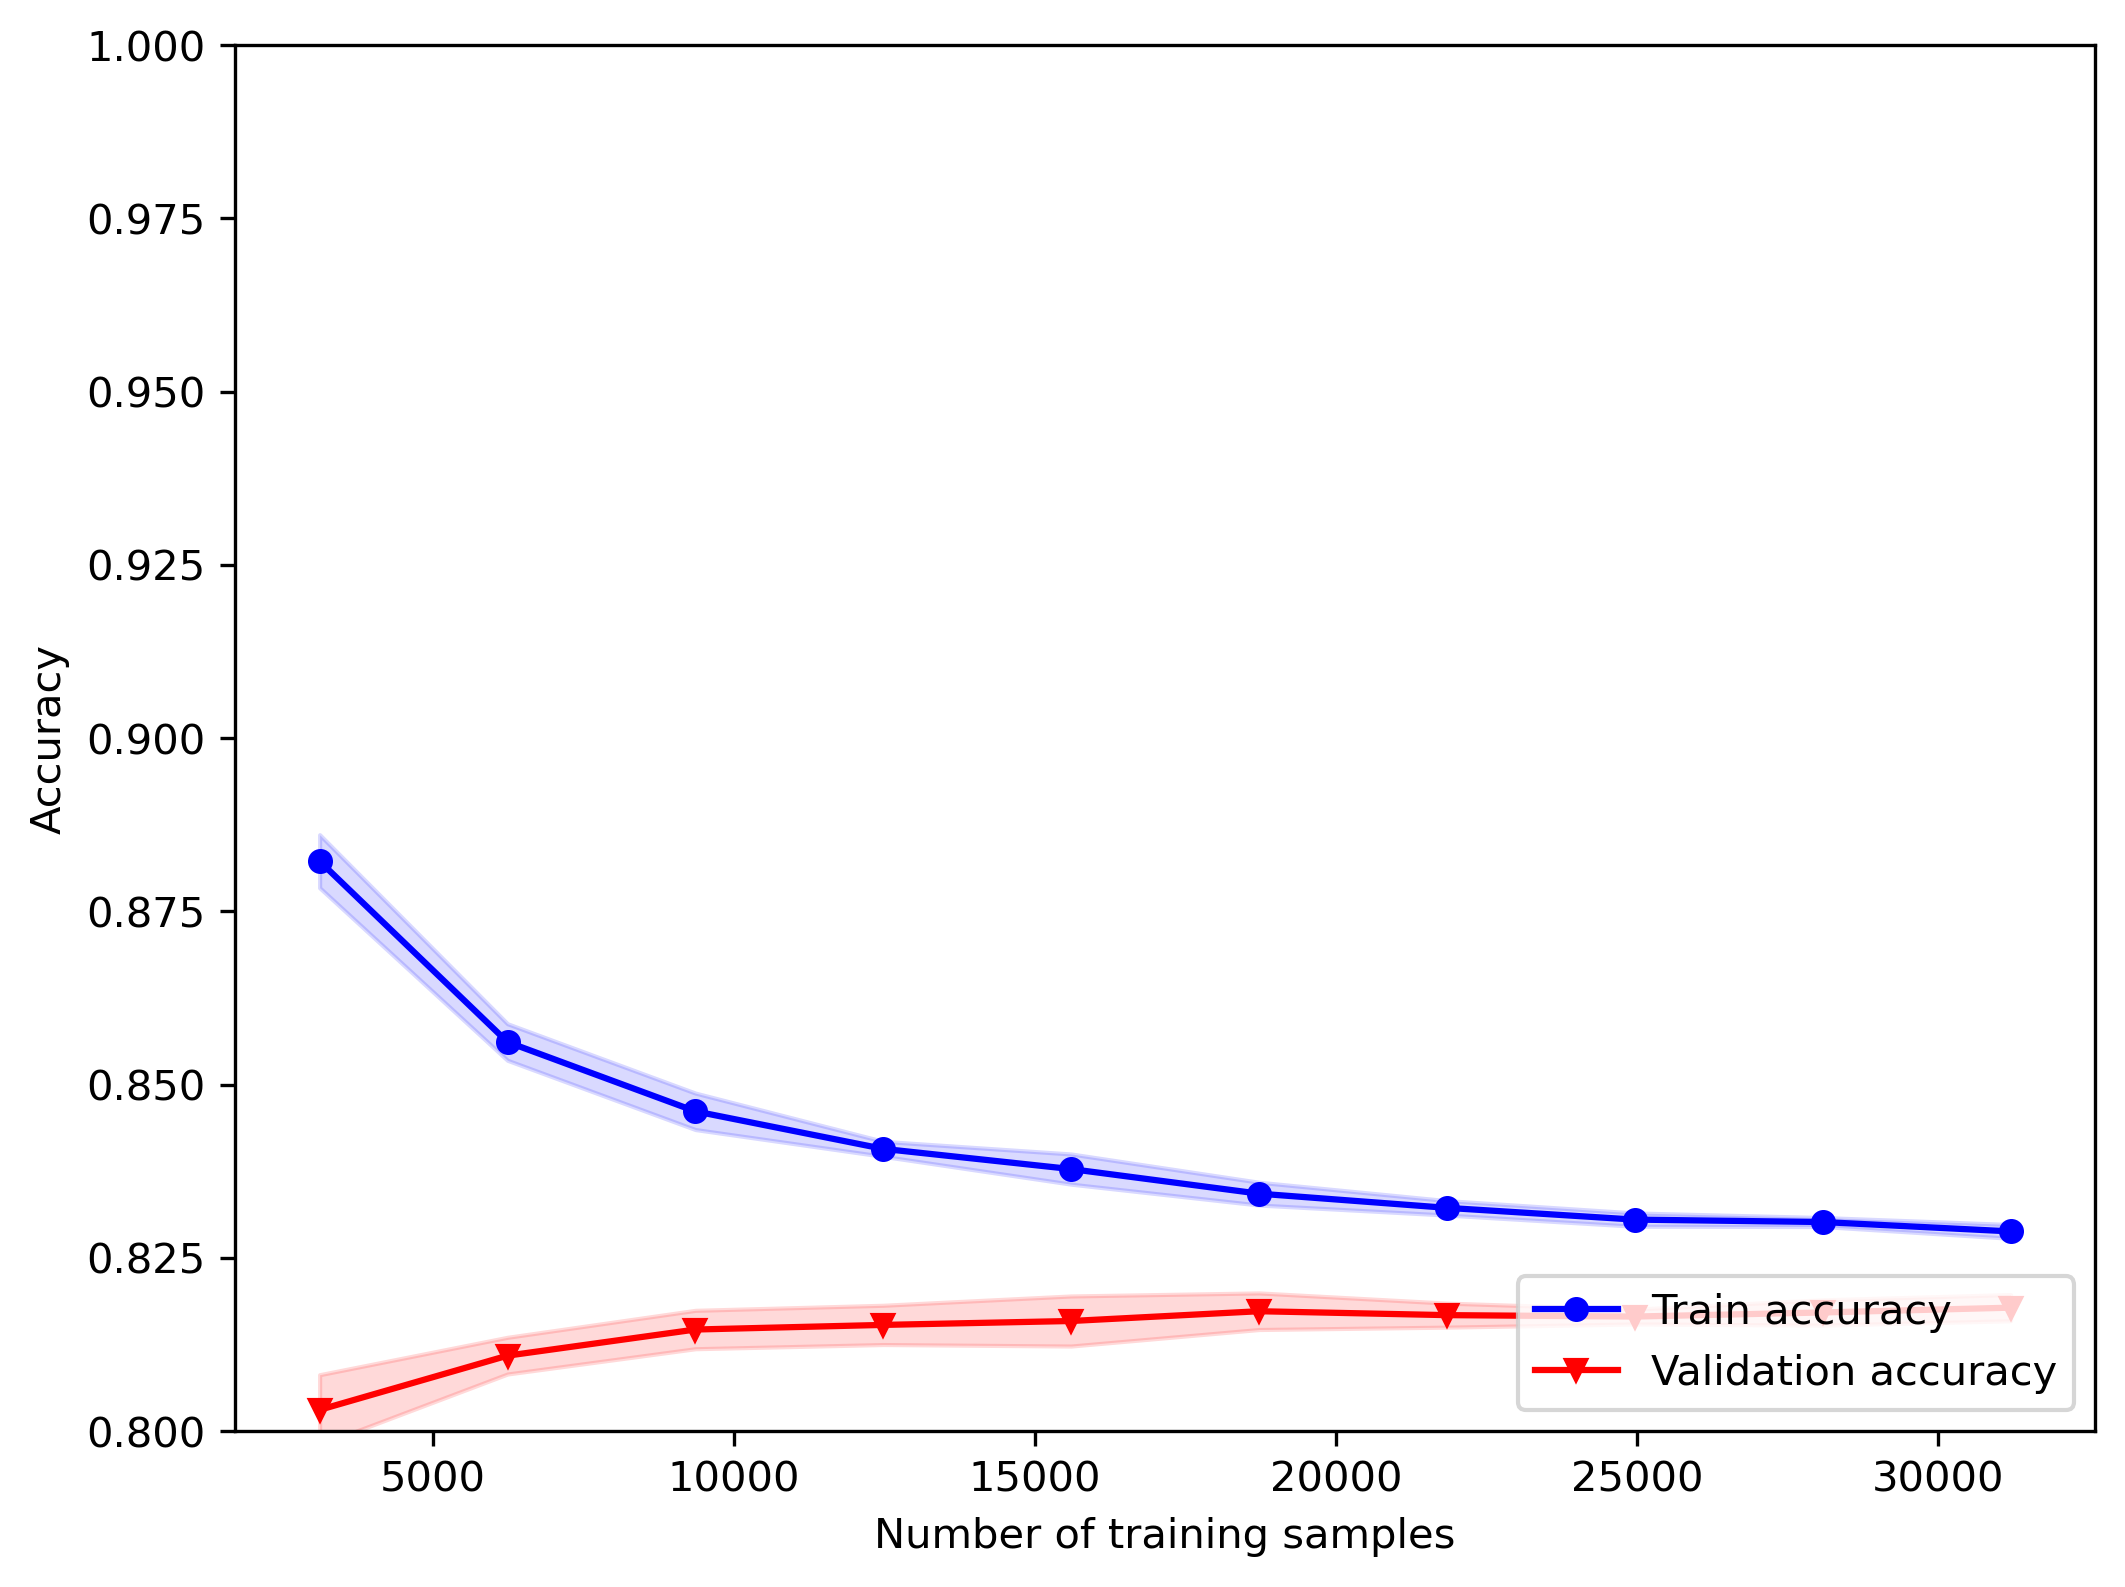

In [42]:
from IPython.display import Image
Image(filename=filename)

# 2nd Trial

In [43]:
# 데이터 로딩
train_data = train['text']  # 훈련 데이터셋
train_labels = train['label']  # 훈련 데이터셋 라벨
test_data = test['text']  # 테스트 데이터셋
test_labels = test['label']  # 테스트 데이터셋 라벨

## 전처리 : 정규화 (표제어 추출)

In [44]:
train_data = [str(text) for text in train_data]
test_data = [str(text) for text in test_data]

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # 불용어 사전 다운로드
nltk.download('wordnet')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
# 형태학적 분석으로 단어의 원형 추출 : 정확한 결과 but 느린 속도
stemmer = PorterStemmer()
# 어미 제거로 어간 추출 : 빠른 속도 but 일부 단어의 원형을 제대로 추출하지 못함

def preprocess_text(text):      
    text = text.lower() # 소문자 변환
    text = re.sub(r'\.+', ' ', text)  # 중복 온점 제거
    text = text.replace('&', 'and') # & 제거
    
    punctuations = '\"#$%*+,/<=>@[\]^_`\\\\{|}?!~:;()'
    for p in punctuations :
        text = text.replace(p, ' ') # 구두점 제거
    
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = re.sub(r'\s+', ' ', text)  # 중복 공백 제거
#     text = re.sub(r'(\w)(\1{1,})', r'\1', text) # 알파벳 3회이상 반복시 1개로
      
#     # 구두점 제거
#     text = ''.join(char for char in text if char not in punctuations)
#     # 불용어 제거
#     text = ' '.join(word for word in text.split() if word not in stop_words)

#     # 표제어 추출
    words = [lemmatizer.lemmatize(word) for word in text.split()]
#     # 어간 추출
#     words = [stemmer.stem(word) for word in text.split()]

#     return ' '.join(words)
    return text.strip()


# train_data와 test_data에 대해 전처리 수행
preprocessed_train_data = [preprocess_text(text) for text in train_data]
preprocessed_test_data = [preprocess_text(text) for text in test_data]

print(train_data[:2])
print(preprocessed_train_data[:2])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


["Awesome Movie: The Cheetah Girls was a great movie. It is one of the best movies I've ever seen. I liked the way the girls danced, but one girl took what they were doing too seriously. I haven't seen the DVD yet,but I saw the movie on Disney channel and I loved it. I can't wait to see the DVD!", "Not what I expect from Dean Koontz: I wish Dean Koontz would get back to the quailty of work I have become used to, as in The Watchers, Dark Rivers of the Heart, Lightning, etc. I could go on and on but his latest works have left me flat. I don't know that I'll read the third book in this series (although I probably will). Come on Dean give me a page turner that I can't put down."]
["awesome movie the cheetah girls was a great movie it is one of the best movies i've ever seen i liked the way the girls danced but one girl took what they were doing too seriously i haven't seen the dvd yet but i saw the movie on disney channel and i loved it i can't wait to see the dvd", "not what i expect from

## 교차검증 사용

     Train Accuracy  Validation Accuracy  Test Accuracy
0.1        0.878034             0.865385       0.869927
0.2        0.900544             0.878205       0.890928
0.3        0.916009             0.884385       0.898465
0.4        0.927966             0.889590       0.908331
0.5        0.937544             0.890359       0.906147
0.6        0.944285             0.893436       0.908515
0.7        0.952368             0.895231       0.914189
0.8        0.958570             0.897154       0.915716
0.9        0.963501             0.898897       0.918419
1.0        0.968034             0.899821       0.916915


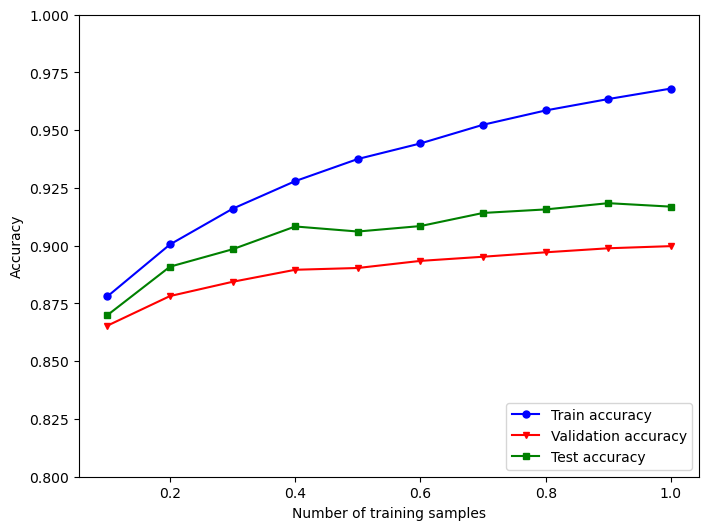

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold #교차검증
import matplotlib.pyplot as plt

# TfidfVectorizer 생성
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1, 2), max_features=10000)

# train 데이터와 validation 데이터를 분리
train_x, valid_x, train_y, valid_y = train_test_split(preprocessed_train_data, train_labels, train_size=0.8, random_state=42)


# SVM 모델 생성
svm_model = LinearSVC(random_state=42)

# 파이프라인 생성
pipeline = Pipeline([
    ('vect', vectorizer),
    ('clf', svm_model),
])


# Stratified K-Fold 교차 검증
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

train_accs = []
valid_accs = []
test_accs = []

train_sizes = np.linspace(0.1, 1.0, 10)

for train_size in train_sizes:
    train_fold_accs = []
    valid_fold_accs = []
    test_fold_accs = []
    
    for train_index, valid_index in kf.split(preprocessed_train_data, train_labels):
        train_x = [preprocessed_train_data[i] for i in train_index]
        valid_x = [preprocessed_train_data[i] for i in valid_index]
        train_y = [train_labels[i] for i in train_index]
        valid_y = [train_labels[i] for i in valid_index]
        
        # 샘플링
        num_samples = int(train_size * len(train_x))
        train_x_cv = train_x[:num_samples]
        train_y_cv = train_y[:num_samples]
        
        # 모델 훈련
        pipeline.fit(train_x_cv, train_y_cv)
        
        # 정확도 계산
        train_acc = accuracy_score(train_y, pipeline.predict(train_x))
        valid_acc = accuracy_score(valid_y, pipeline.predict(valid_x))
        test_acc = accuracy_score(test_labels, pipeline.predict(preprocessed_test_data))
        
        train_fold_accs.append(train_acc)
        valid_fold_accs.append(valid_acc)
        test_fold_accs.append(test_acc)
        
    train_accs.append(np.mean(train_fold_accs))
    valid_accs.append(np.mean(valid_fold_accs))
    test_accs.append(np.mean(test_fold_accs))
    

df = pd.DataFrame({
    'Train Accuracy': train_accs,
    'Validation Accuracy': valid_accs,
    'Test Accuracy': test_accs
}, index=train_sizes)

print(df)


# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_accs, color='blue', marker='o', markersize=5, label='Train accuracy')
plt.plot(train_sizes, valid_accs, color='red', marker='v', markersize=5, label='Validation accuracy')
plt.plot(train_sizes, test_accs, color='green', marker='s', markersize=5, label='Test accuracy')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

### 91.39%

In [49]:
# 모델 성능 평가
train_predicted_labels = pipeline.predict(train_x)
train_accuracy = accuracy_score(train_y, train_predicted_labels)
print(f"Train Accuracy: {train_accuracy:.4f}")

# 검증 데이터로 모델 평가
valid_predicted_labels = pipeline.predict(valid_x)
valid_accuracy = accuracy_score(valid_y, valid_predicted_labels)
print(f"Validation Accuracy: {valid_accuracy:.4f}")

# 테스트 데이터로 모델 성능 평가
test_predicted_labels = pipeline.predict(preprocessed_test_data)
test_accuracy = accuracy_score(test_labels, test_predicted_labels)
print(f"Test Accuracy with best parameters: {test_accuracy:.4f}")

Train Accuracy: 0.9675
Validation Accuracy: 0.9051
Test Accuracy with best parameters: 0.9139


In [50]:
from sklearn.metrics import classification_report, confusion_matrix

print("Test")
# 혼동 행렬 출력
print(confusion_matrix(test_labels, test_predicted_labels))
# 분류 보고서 출력
print(classification_report(test_labels, test_predicted_labels))

Test
[[ 1733    95]
 [ 1033 10234]]
              precision    recall  f1-score   support

           0       0.63      0.95      0.75      1828
           1       0.99      0.91      0.95     11267

    accuracy                           0.91     13095
   macro avg       0.81      0.93      0.85     13095
weighted avg       0.94      0.91      0.92     13095



### 과적합 검증

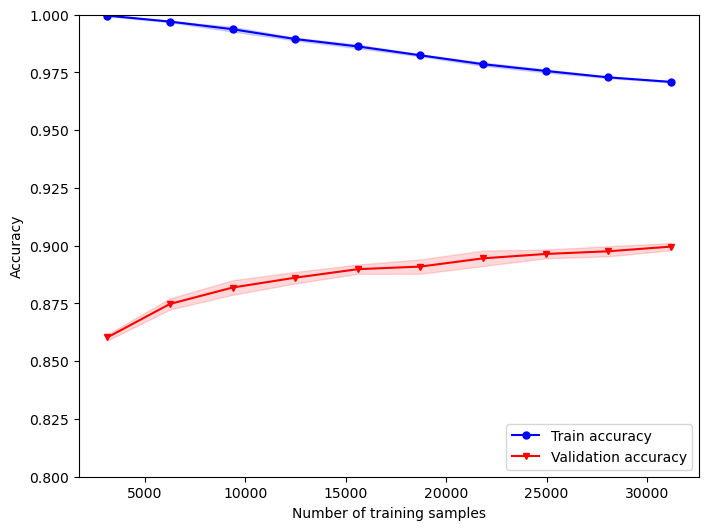

In [51]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=pipeline,
    X=preprocessed_train_data, y=train_labels,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)


plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Train accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, validation_mean, color='red', marker='v', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, validation_mean + validation_std, validation_mean - validation_std, alpha=0.15, color='red')


plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])

# 그래프를 이미지 파일로 저장합니다.
filename = 'GB_Open_교차검증.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

## 이미지 저장

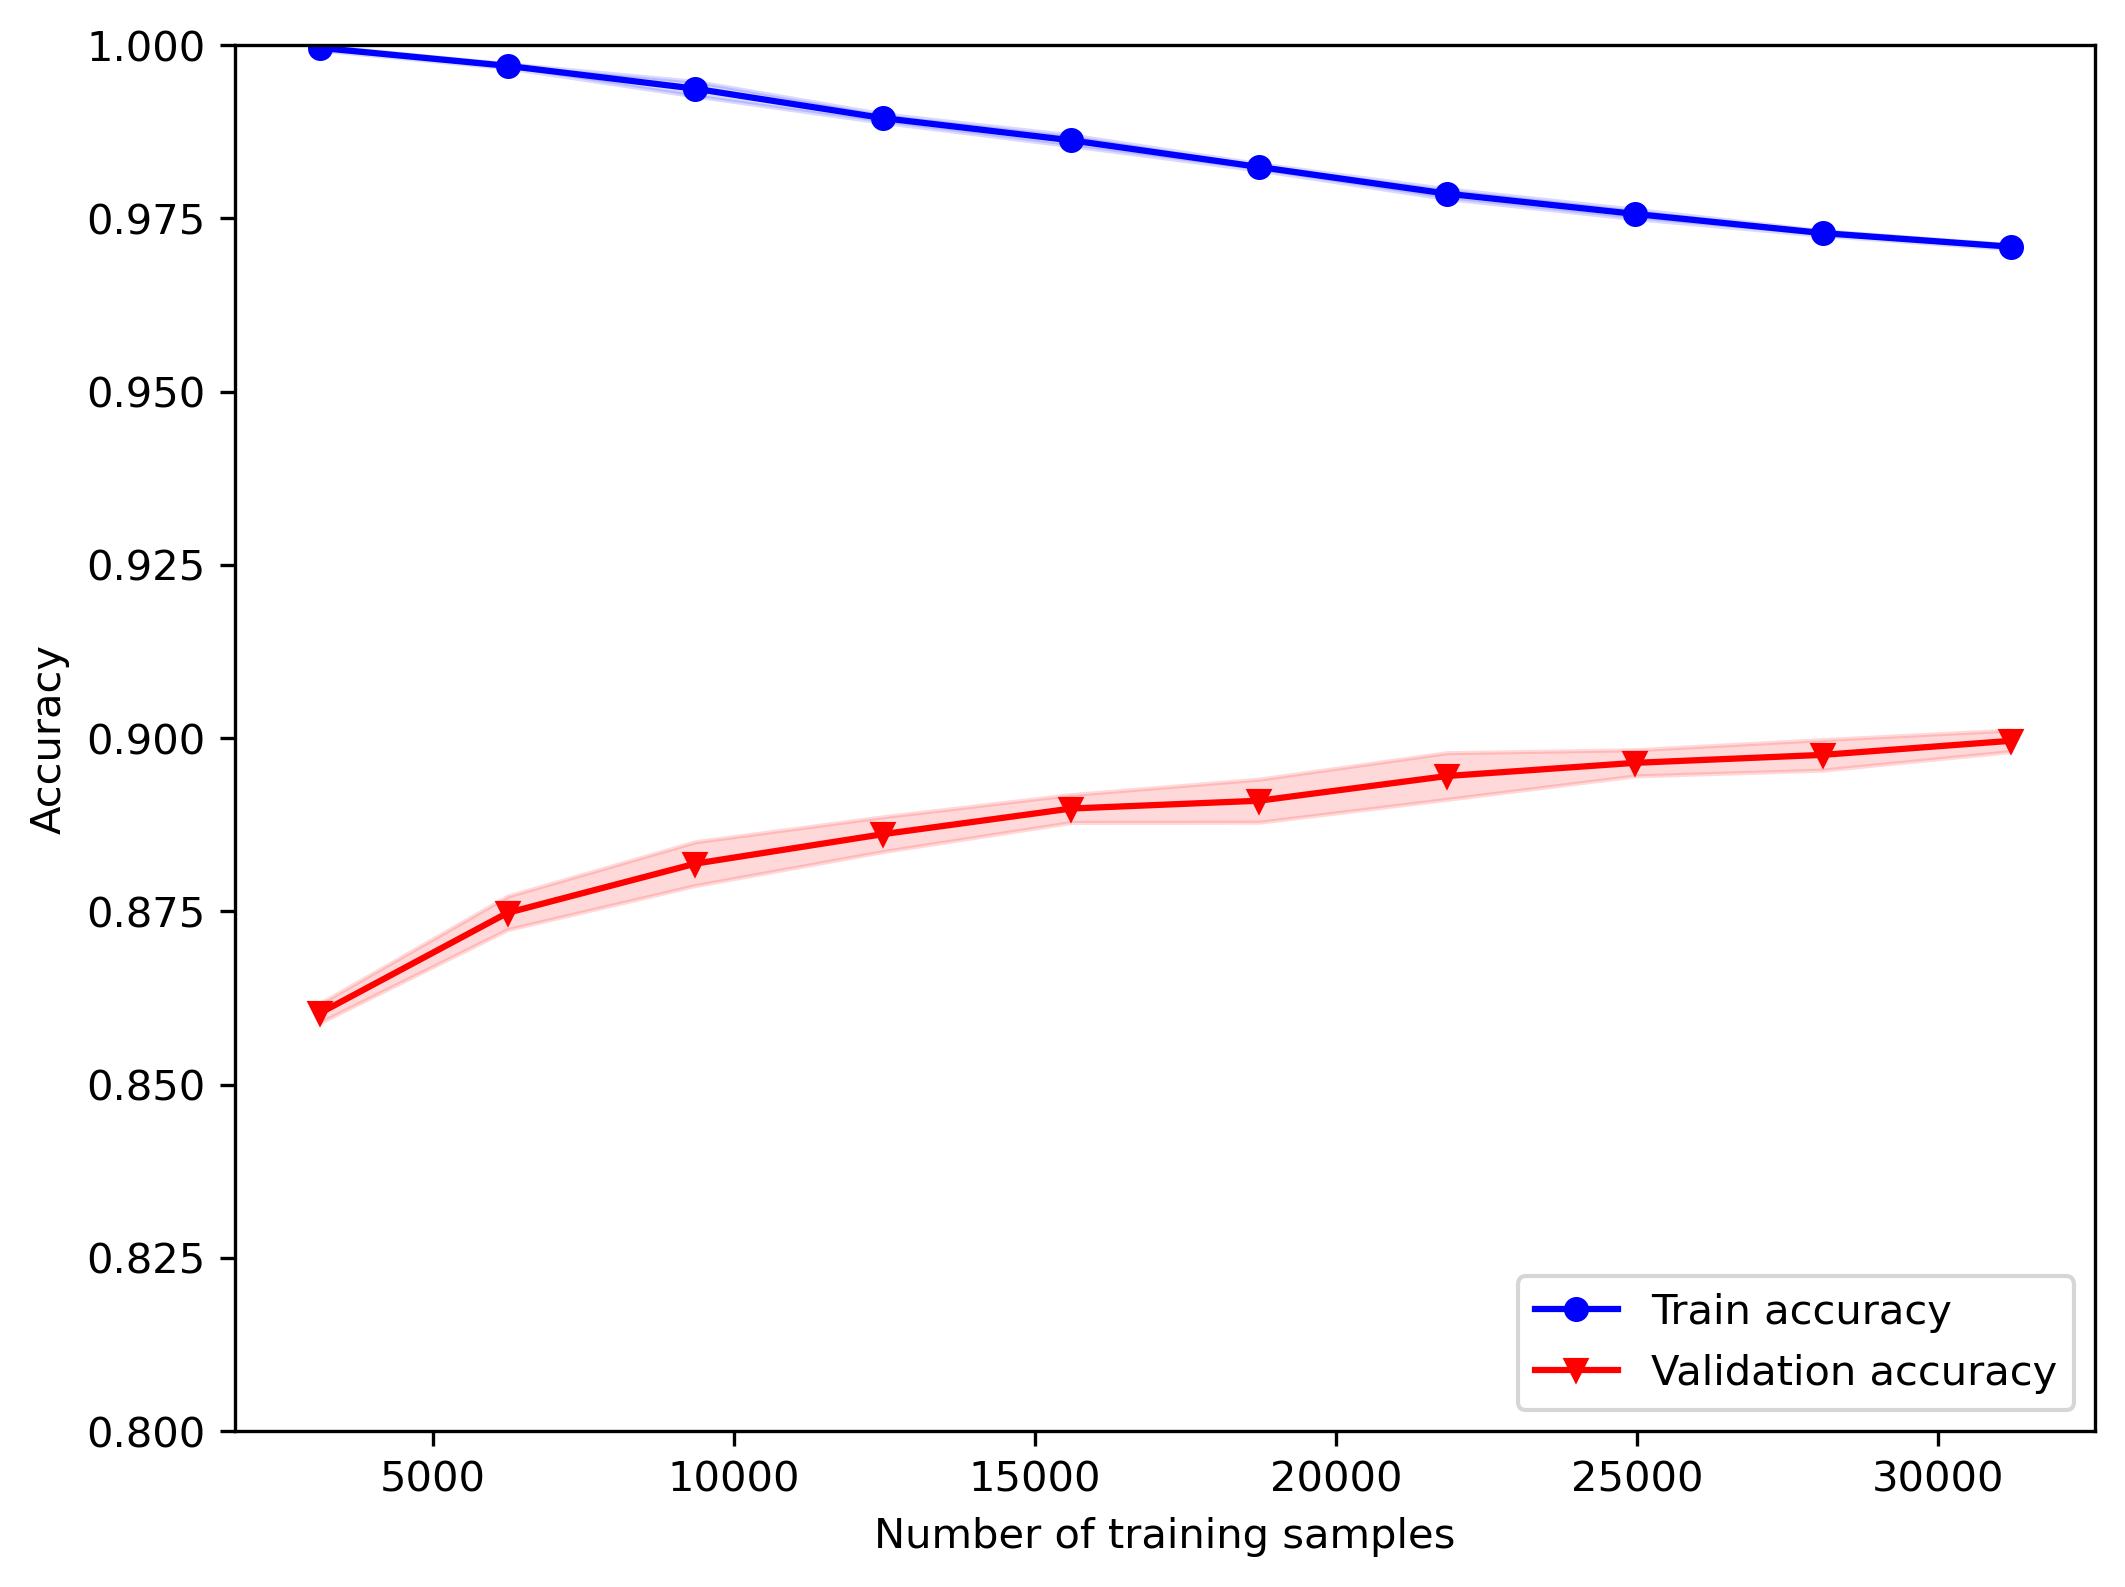

In [52]:
from IPython.display import Image
Image(filename=filename)

### cross_validate

In [53]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

result = cross_validate(pipeline, train_data, train_labels, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])
# scoring : 평가지표의 이름을 리스트로 전달
# accuracy 정확도 / precision_macro 정밀도 / roc_auc_ovr

for key, val in result.items():
    # 딕셔너리 객체로 반환된 result를 items 함수를 통해 key와 value를 모두 받기
    print('평가지표: ', key)
    print(f'평균값: {np.mean(val):.2f}')
    print('-'*30)

# fit_time : 학습시간
# score_time : 검증시간
# 나머지 : 1에 가까울 수록 좋다.

평가지표:  fit_time
평균값: 8.92
------------------------------
평가지표:  score_time
평균값: 1.22
------------------------------
평가지표:  test_accuracy
평균값: 0.90
------------------------------
평가지표:  test_precision_macro
평균값: 0.90
------------------------------
평가지표:  test_recall_macro
평균값: 0.89
------------------------------


# 3rd Trial

In [7]:
# 데이터 로딩
train_data = train['text']  # 훈련 데이터셋
train_labels = train['label']  # 훈련 데이터셋 라벨
test_data = test['text']  # 테스트 데이터셋
test_labels = test['label']  # 테스트 데이터셋 라벨

In [8]:
train_data = [str(text) for text in train_data]
test_data = [str(text) for text in test_data]

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # 불용어 사전 다운로드
nltk.download('wordnet')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
# 형태학적 분석으로 단어의 원형 추출 : 정확한 결과 but 느린 속도
stemmer = PorterStemmer()
# 어미 제거로 어간 추출 : 빠른 속도 but 일부 단어의 원형을 제대로 추출하지 못함

def preprocess_text(text):      
    text = text.lower() # 소문자 변환
    text = re.sub(r'\.+', ' ', text)  # 중복 온점 제거
    text = text.replace('&', 'and') # & 제거
    
    punctuations = '\"#$%*+,/<=>@[\]^_`\\\\{|}?!~:;()'
    for p in punctuations :
        text = text.replace(p, ' ') # 구두점 제거
    
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = re.sub(r'\s+', ' ', text)  # 중복 공백 제거
#     text = re.sub(r'(\w)(\1{1,})', r'\1', text) # 알파벳 3회이상 반복시 1개로
      
#     # 구두점 제거
#     text = ''.join(char for char in text if char not in punctuations)
#     # 불용어 제거
#     text = ' '.join(word for word in text.split() if word not in stop_words)

#     # 표제어 추출
    words = [lemmatizer.lemmatize(word) for word in text.split()]
#     # 어간 추출
#     words = [stemmer.stem(word) for word in text.split()]

#     return ' '.join(words)
    return text.strip()


# train_data와 test_data에 대해 전처리 수행
preprocessed_train_data = [preprocess_text(text) for text in train_data]
preprocessed_test_data = [preprocess_text(text) for text in test_data]

print(train_data[:2])
print(preprocessed_train_data[:2])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


["Awesome Movie: The Cheetah Girls was a great movie. It is one of the best movies I've ever seen. I liked the way the girls danced, but one girl took what they were doing too seriously. I haven't seen the DVD yet,but I saw the movie on Disney channel and I loved it. I can't wait to see the DVD!", "Not what I expect from Dean Koontz: I wish Dean Koontz would get back to the quailty of work I have become used to, as in The Watchers, Dark Rivers of the Heart, Lightning, etc. I could go on and on but his latest works have left me flat. I don't know that I'll read the third book in this series (although I probably will). Come on Dean give me a page turner that I can't put down."]
["awesome movie the cheetah girls was a great movie it is one of the best movies i've ever seen i liked the way the girls danced but one girl took what they were doing too seriously i haven't seen the dvd yet but i saw the movie on disney channel and i loved it i can't wait to see the dvd", "not what i expect from

## gradient boosting 사용

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# 벡터화를 위한 파라미터 설정
# stop_words='english',
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_features=10000)
tfidf_transformer = TfidfTransformer()

# train 데이터와 validation 데이터를 분리
train_x, valid_x, train_y, valid_y = train_test_split(preprocessed_train_data, train_labels, train_size=0.8, random_state=42)

# GBM 모델 생성
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

# 파이프라인 생성
pipeline = Pipeline([
    ('vect', vectorizer),
    ('tfidf', tfidf_transformer),
    ('clf', gbm_model),
])

# 모델 훈련
pipeline.fit(train_x, train_y)

print('end')

end


## 하이퍼 파라미터 튜닝

In [10]:
# 최적의 하이퍼파라미터를 찾기 위해 GridSearchCV를 사용
from sklearn.model_selection import GridSearchCV

parameters = {
    'vect__max_features': [5000, 10000, 15000],
    'clf__n_estimators': [50, 100, 150],
    'clf__max_depth': [3, 4, 5],
    'tfidf__use_idf': [True, False],
}

# 'vect__max_features': 문서에서 단어장으로 만들 최대 단어 수 (5000, 10000, 15000 중 선택)
# 'clf__n_estimators': 랜덤 포레스트에서 사용될 결정 트리의 개수 (50, 100, 150 중 선택)
# 'clf__max_depth': 결정 트리의 최대 깊이 (3, 4, 5 중 선택)
# 'tfidf__use_idf': TF-IDF 가중치 사용 여부 (True, False 중 선택)

gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
# cv : 교차검증 획수 (DEFAULT:5)
# n_jobs :하이퍼파라미터튜닝시 사용하는 코어의 개수 (DEFAULT:-1 모든 코어 사용)
gs.fit(train_data, train_labels)

print('최적 파라미터', gs.best_params_)
print('최적 정확도', gs.best_score_)

# 최적의 파라미터로 모델 생성
best_model = gs.best_estimator_

최적 파라미터 {'clf__max_depth': 5, 'clf__n_estimators': 150, 'tfidf__use_idf': False, 'vect__max_features': 10000}
최적 정확도 0.853051282051282


### 84.59%

In [11]:
# 모델 성능 평가
train_predicted_labels = best_model.predict(train_x)
train_accuracy = accuracy_score(train_y, train_predicted_labels)
print(f"Train Accuracy: {train_accuracy:.4f}")

# 검증 데이터로 모델 평가
valid_predicted_labels = best_model.predict(valid_x)
valid_accuracy = accuracy_score(valid_y, valid_predicted_labels)
print(f"Validation Accuracy: {valid_accuracy:.4f}")

# 테스트 데이터로 모델 성능 평가
test_predicted_labels = best_model.predict(preprocessed_test_data)
test_accuracy = accuracy_score(test_labels, test_predicted_labels)
print(f"Test Accuracy with best parameters: {test_accuracy:.4f}")

Train Accuracy: 0.8862
Validation Accuracy: 0.8891
Test Accuracy with best parameters: 0.8459


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print("Test")
# 혼동 행렬 출력
print(confusion_matrix(test_labels, test_predicted_labels))
# 분류 보고서 출력
print(classification_report(test_labels, test_predicted_labels))

Test
[[1698  130]
 [1888 9379]]
              precision    recall  f1-score   support

           0       0.47      0.93      0.63      1828
           1       0.99      0.83      0.90     11267

    accuracy                           0.85     13095
   macro avg       0.73      0.88      0.77     13095
weighted avg       0.91      0.85      0.86     13095



### 과적합 검증

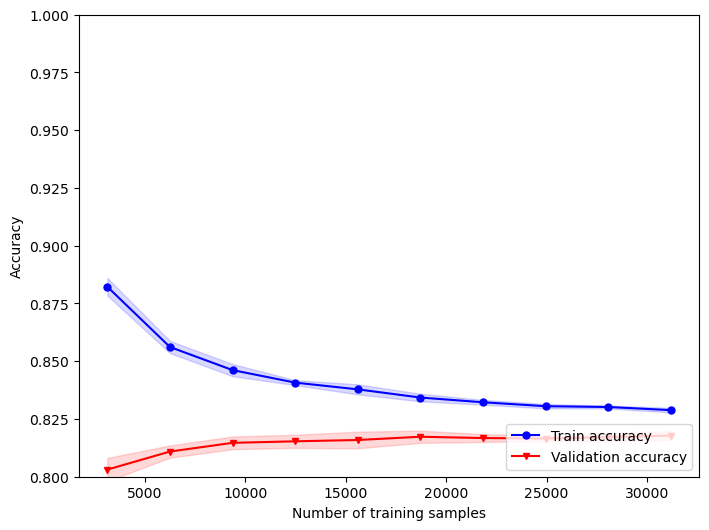

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=pipeline,
    X=preprocessed_train_data, y=train_labels,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)


plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Train accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, validation_mean, color='red', marker='v', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, validation_mean + validation_std, validation_mean - validation_std, alpha=0.15, color='red')


plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])

# 그래프를 이미지 파일로 저장합니다.
filename = 'GB_Open_하이퍼파라미터튜닝.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

## 이미지 저장

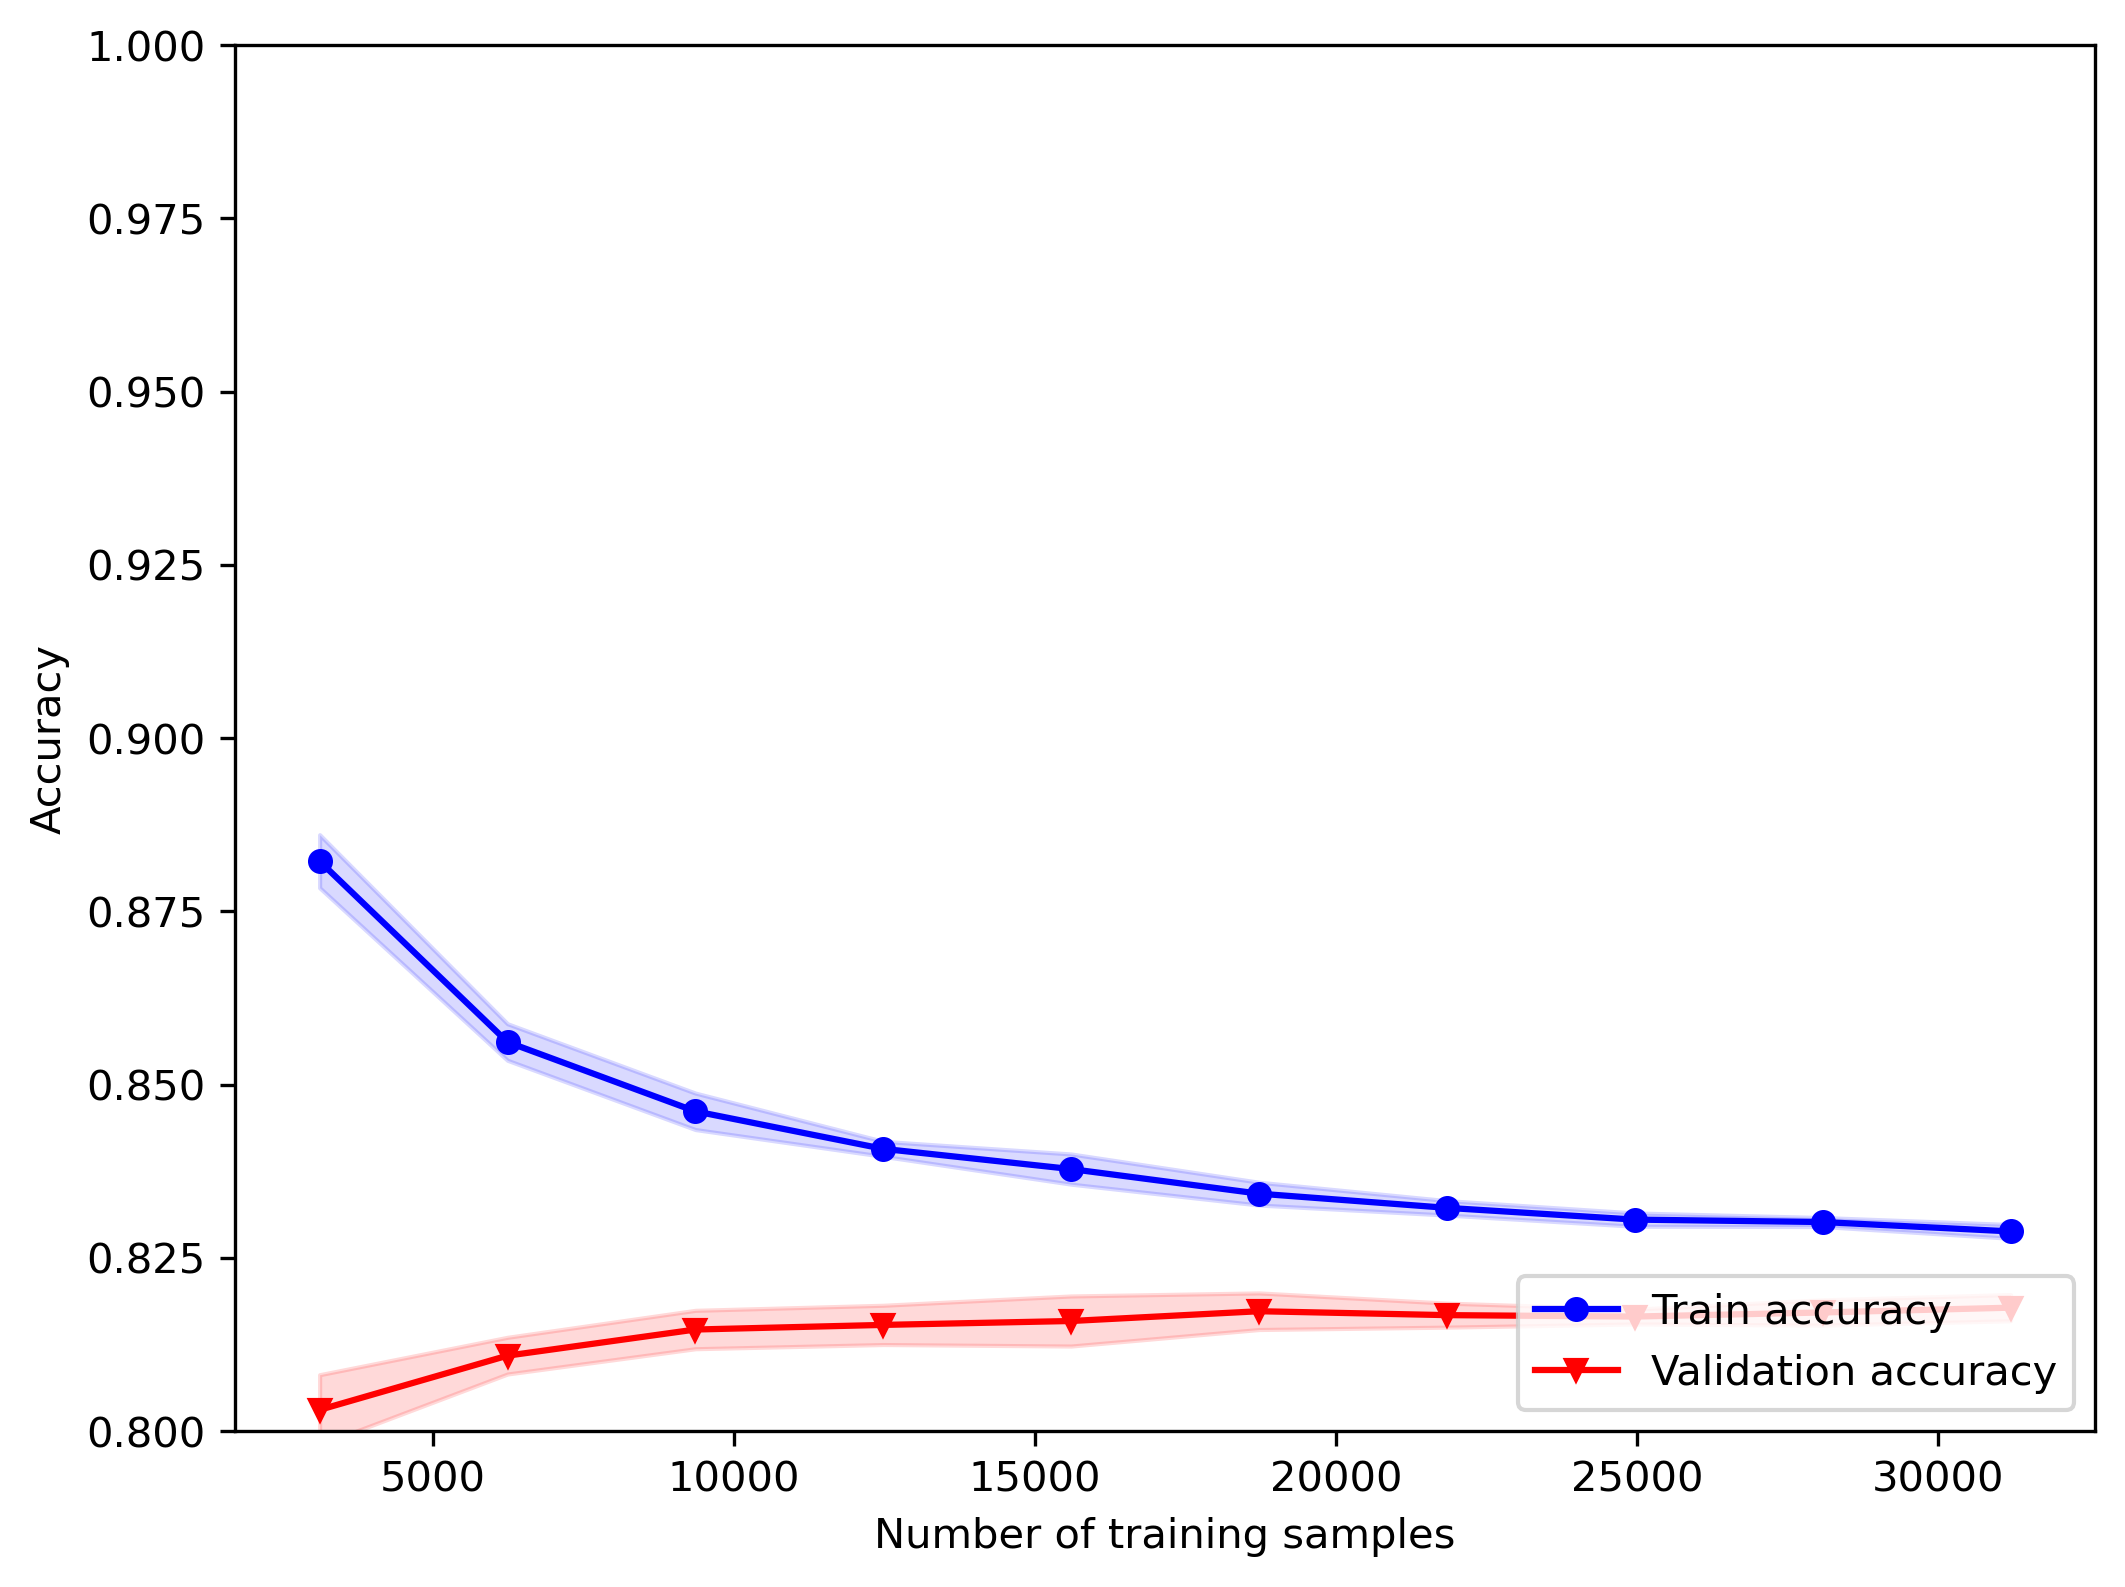

In [14]:
from IPython.display import Image
Image(filename=filename)